# The goal of this notebook is to calculcate the impact of single terms (unigrams) on the polarity scores of sentences - publications - journals - publication sources 

A few different ways are used to approximate the influence of a single term

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, SentiText, VaderConstants
from nltk import tokenize

In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from tqdm import tqdm

### Import dataset

In [3]:
ALLEN_AI_SUBS_PATH = "../res/allenai/metadata_subset.csv"

df_allen = pd.read_csv(ALLEN_AI_SUBS_PATH)[['source_x', 'title', 'abstract', 'publish_time', 'journal', 'is_pr']]
df_allen = df_allen.fillna('')

print(len(df_allen.index))
df_allen.head(5)

58007


,source_x,title,abstract,publish_time,journal,is_pr
0,PMC,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,The EMBO Journal,True
1,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,The EMBO Journal,True
2,PMC,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,EMBO J,True
3,PMC,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,The EMBO Journal,True
4,PMC,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,The EMBO Journal,True


In [4]:
raw_txt = df_allen[['title', 'abstract']].agg(' - '.join, axis=1)
raw_txt.values[:2]

array(['Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis - Nidovirus subgenomic mRNAs contain a leader sequence derived from the 5′ end of the genome fused to different sequences (‘bodies’) derived from the 3′ end. Their generation involves a unique mechanism of discontinuous subgenomic RNA synthesis that resembles copy-choice RNA recombination. During this process, the nascent RNA strand is transferred from one site in the template to another, during either plus or minus strand synthesis, to yield subgenomic RNA molecules. Central to this process are transcription-regulating sequences (TRSs), which are present at both template sites and ensure the fidelity of strand transfer. Here we present results of a comprehensive co-variation mutagenesis study of equine arteritis virus TRSs, demonstrating that discontinuous RNA synthesis depends not only on base pairing between sense leader TRS and antisense body TRS, but also on the primary se

## Variante A - Using just the values from the valence lexicon

This does not take into considerations closeness to degree adverbs (https://en.wiktionary.org/wiki/Category:English_degree_adverbs), Negations and other tweaks of the vader implementation  
Out-of-Vocabulary words are treated as neutral terms

In [5]:
sid = SentimentIntensityAnalyzer()
vader_constants = VaderConstants()
print("Top 10 positive terms")
print([(x, sid.lexicon[x]) for x in sorted(sid.lexicon, key=sid.lexicon.get, reverse=True)[:10]])
print("Top 10 negative terms")
print([(x, sid.lexicon[x]) for x in sorted(sid.lexicon, key=sid.lexicon.get)[:10]])

Top 10 positive terms
[('aml', 3.4), ('ilu', 3.4), ('ily', 3.4), ('magnificently', 3.4), ('lya', 3.3), ('ecstacy', 3.3), ('euphoria', 3.3), ('sweetheart', 3.3), ('143', 3.2), ('best', 3.2)]
Top 10 negative terms
[('rapist', -3.9), ('raping', -3.8), ('slavery', -3.8), ('fu', -3.7), ('kill', -3.7), ('murder', -3.7), ('rape', -3.7), ('terrorist', -3.7), ('hatefulness', -3.6), ('hell', -3.6)]


##### The top 10 positive words already indicate that Vader is more useful for domains like social media. A lot of abbreviations for 'i love you' are found at the top

#### Calculate per sentence polarity impact
Here I normalize the impact in a similar way to the Vader implementation (see https://www.nltk.org/api/nltk.sentiment.html#nltk.sentiment.vader.SentimentIntensityAnalyzer.score_valence). Punctuation amplifiers are taken into account on sentence level, so I do not include them on a term-base calculation.  
Note that the nltk Vader implementation adds the scalar 1 for positive terms and -1 for negative terms to account for the impact of neutral terms. e.g. the sentence `good or bad` is mapped first to lexicon values `[1.9, 0, -2.5]` and then translated to polarity impact scores `[2.9, 1, -3.5]`. The sum of absolute values (in this case `7.4`) is used for normalization.  
For neutral terms the polarity impact is fixed to `0`. This is a simplification for this calculation, removing a neutral term would increase the polarity impact of non-neutral terms in the actual implementation. For `good` the calculated impact is `2.9/7.4` for `bad` it is `-3.5/7.4`  
The polarity score of a term is multiplied by the number of it's occurences in the string

In [6]:
def clean_text(sentence):
    # this is done using the Vader implementation of nltk - it is a very simple nlp pre-processing function, which performs mainly punctuation removal
    sentitext = SentiText(sentence, vader_constants.PUNC_LIST, vader_constants.REGEX_REMOVE_PUNCTUATION)
    return [x.lower() for x in sentitext.words_and_emoticons]

def get_polarity_impact(term):
    valence = sid.lexicon.get(term) or 0
    return valence + 1 if valence >= 0 else valence -1 # neutral terms reduce impact of non-neutral terms

def get_sentence_polarity_impact_map(sentence):
    term_scores = dict()
    cleaned_sentence = clean_text(sentence)
    
    # aggregate term polarity impact per unique term
    for term in cleaned_sentence:
        if not term in term_scores:
            term_scores[term] = 0
        term_scores[term] += get_polarity_impact(term)
    
    total_impact_sum = sum([abs(x) for x in term_scores.values()])
    term_scores.update({term: term_impact/total_impact_sum if sid.lexicon.get(term) else 0 for term, term_impact in term_scores.items()})
    
    return {k:term_scores[k] for k in term_scores if term_scores[k] != 0}

For simple sentences this gives a good explanation of the polarity scores

In [7]:
get_sentence_polarity_impact_map("Well, this is bad")

{'well': 0.27631578947368424, 'bad': -0.46052631578947373}

In [8]:
sid.polarity_scores("Well, this is bad")

{'neg': 0.461, 'neu': 0.263, 'pos': 0.276, 'compound': -0.34}

Keep in mind: For more complex sentences (with negations, etc.) this does not work 

In [9]:
get_sentence_polarity_impact_map("Very well, but this is not better")

{'well': 0.21000000000000002, 'better': 0.29}

In [10]:
sid.polarity_scores("Very well, but this is not better")

{'neg': 0.317, 'neu': 0.51, 'pos': 0.173, 'compound': -0.3426}

### Calculate per document polarity impact
Here I chose to average individual impacts out over all sentences, i.e. sum up individual word impacts and divide by the number of sentences

In [11]:
def get_document_polarity_impact_map(doc):
    term_scores = dict()
    sentences = tokenize.sent_tokenize(doc)
    cnt_sentences = len(sentences)
    for sentence in sentences:
        sentence_term_map = get_sentence_polarity_impact_map(sentence)
        for term in sentence_term_map:
            term_scores[term] = term_scores.get(term, 0) + sentence_term_map[term]/cnt_sentences
    return term_scores        

In [12]:
get_document_polarity_impact_map("This sentence is used as an example for good and bad terms. The terms good and bad occur in both sentences")

{'sentence': 0.03892215568862275,
 'good': 0.19344399436421272,
 'bad': -0.23346688974991192,
 'sentences': 0.04411764705882353}

### Calculate per group polarity impact
Pretty similar to the document aggregation, here we average the impact over all documents within a group of documents

In [13]:
def get_group_polarity_impact_map(documents):
    term_scores = dict()
    cnt_docs = len(documents)
    for doc in tqdm(documents):
        doc_term_map = get_document_polarity_impact_map(doc)
        for term in doc_term_map:
            term_scores[term] = term_scores.get(term, 0) + doc_term_map[term]/cnt_docs
    return term_scores

In [14]:
get_group_polarity_impact_map(raw_txt[:5])

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.34it/s]


{'ensure': 0.0031476997578692495,
 'comprehensive': 0.0012987012987012987,
 'plays': 0.0031746031746031746,
 'strongly': 0.002843601895734597,
 'exploration': 0.0025435073627844713,
 'novel': 0.009068342337523674,
 'important': 0.004191804211724531,
 'mature': 0.0032258064516129024,
 'natural': 0.002197802197802198,
 'low': -0.0012773722627737226,
 'active': 0.0021774193548387095,
 'united': 0.0021705426356589145,
 'best': 0.003206106870229008,
 'lack': -0.0044660194174757275,
 'surprisingly': 0.0027160493827160497}

### Applying it to cord-19 sources

In [15]:
source_term_maps = dict()
sources = df_allen.source_x.unique()
for source in sources:
    print("Calculating for", source)
    docs = raw_txt[df_allen.source_x == source]
    source_term_maps[source] = get_group_polarity_impact_map(docs)

  0%|                                                                              | 21/32223 [00:00<02:34, 207.93it/s]

Calculating for PMC


  0%|▏                                                                             | 55/20898 [00:00<00:38, 544.45it/s]

Calculating for Elsevier


 62%|█████████████████████████████████████████████████▌                              | 62/100 [00:00<00:00, 607.85it/s]

Calculating for CZI


  5%|███▉                                                                            | 45/918 [00:00<00:01, 449.91it/s]

Calculating for WHO


  3%|██▎                                                                            | 31/1064 [00:00<00:03, 295.19it/s]

Calculating for biorxiv


  2%|█▌                                                                             | 41/2007 [00:00<00:04, 401.98it/s]

Calculating for medrxiv


  4%|███▌                                                                            | 35/797 [00:00<00:02, 349.92it/s]

Calculating for arxiv


100%|███████████████████████████████████████████████████████████████████████████████| 797/797 [00:02<00:00, 380.90it/s]


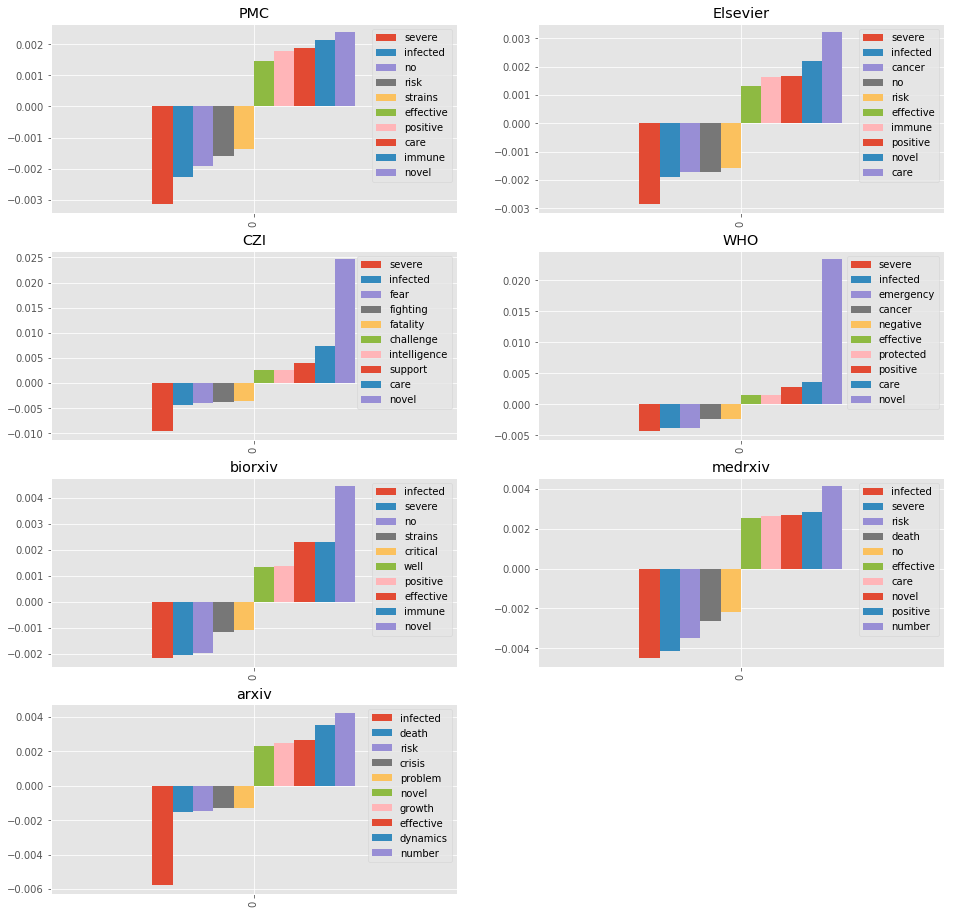

In [16]:
fig = plt.figure(figsize=(16,16))
for i, source in enumerate(sources):
    ax = fig.add_subplot(math.ceil(len(sources)/2),2,i+1)
    sorted_term_keys = sorted(source_term_maps[source], key=source_term_maps[source].get)
    top_term_map = {**{x:source_term_maps[source][x] for x in sorted_term_keys[:5]},**{x:source_term_maps[source][x] for x in sorted_term_keys[-5:]}}
    pd.DataFrame(top_term_map, index=[0]).plot(kind='bar', title=source, ax=ax)

In [17]:
def show_term_impact(term):
    source_map = {source:source_term_maps[source].get(term,0) for source in sources}
    print(source_map)
    pd.DataFrame(source_map, index=[0]).plot(kind='bar', title=f'Polarity impact of {term}', figsize=(4,4))

{'PMC': 0.0023785516585170634, 'Elsevier': 0.0021970029377585245, 'CZI': 0.02464067962162597, 'WHO': 0.023373475505300393, 'biorxiv': 0.004435865873670101, 'medrxiv': 0.002675886336955419, 'arxiv': 0.0023280900725307454}


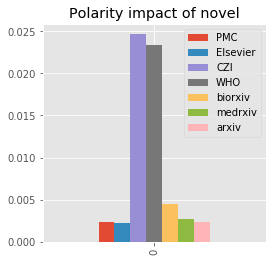

In [18]:
show_term_impact('novel')